In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
import pandas as pd

# astropy
# from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
# from astropy.coordinates import SkyCoord, FK5
from astropy.visualization.wcsaxes import add_beam, add_scalebar
# import aplpy
from regions import Regions

# matplotlib
import matplotlib.pyplot as plt
# import matplotlib.ticker as mticker
# from matplotlib.patches import Circle, Ellipse
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
# from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import AsinhNorm

from copy import copy

%matplotlib inline

In [2]:
hc3nfile = 'data/NGC1333_HC3N_L24-merged_small_K.fits'
hc3nmom0file = 'data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0.fits'
hc3nrmsfile = 'data/NGC1333_HC3N_L24-merged_small_K_rms.fits'
sourcecat = 'data/Enoch_2009_sources_NGC1333_SE.csv'

ncompfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC.fits'
ncompflagfile = 'first_look/gaussfit/diagnosticAIC/ncomponents_AIC_flag.fits'

In [3]:
mom0, header2d = fits.getdata(hc3nmom0file, header=True)
wcs = WCS(header2d)
bmaj, bmin, bpa = np.array([header2d['bmaj'], header2d['bmin'], header2d['bpa']]) * u.deg
cubehc3n = SpectralCube.read(hc3nfile)
catalog_protostars = pd.read_csv(sourcecat)
ncomp = fits.getdata(ncompfile)
ncompflag = fits.getdata(ncompflagfile)

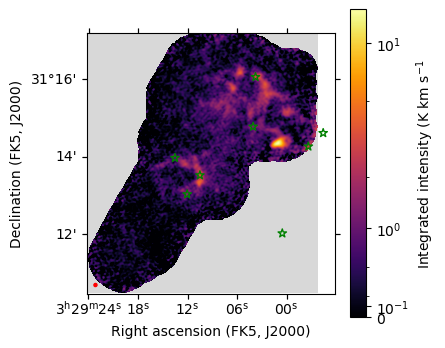

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4,4), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('inferno').copy()
cmap.set_bad('0.85')
norm = AsinhNorm(linear_width=0.8, vmin=0)

im = ax.imshow(mom0, cmap=cmap,norm=norm)
fig.colorbar(im, ax=ax, label=r'Integrated intensity (K km s$^{-1}$')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (FK5, J2000)')
lat.set_axislabel('Declination (FK5, J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, '_RAJ2000'], catalog_protostars.loc[i, '_DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='None', edgecolor='g', s=40)
fig.savefig('figures/HC3N_mom0.pdf', bbox_inches='tight', dpi=100)

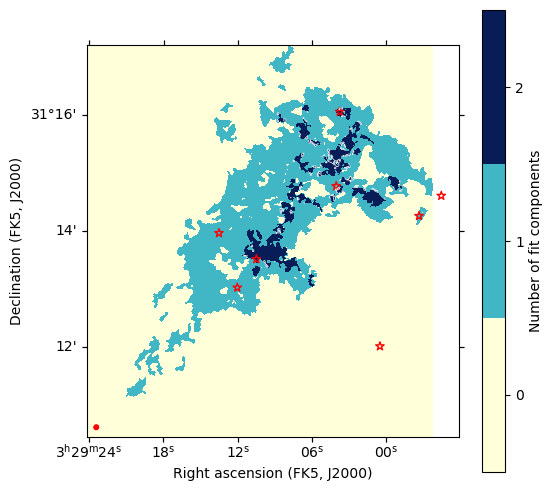

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw={'projection': wcs})
cmap = cm.get_cmap('YlGnBu', 3).copy()
cmap.set_bad('0.85')
ncomp[np.where(np.isnan(ncomp))] = 0
ncompflag[np.where(np.isnan(ncompflag))] = 0.

sc1 = ax.imshow(ncomp,  cmap=cmap, vmin=-0.5, vmax=2.5)
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4))
ax.contour(ncompflag, levels=[0.5], colors='w', linewidths=0.5)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_axislabel('Right ascension (FK5, J2000)')
lat.set_axislabel('Declination (FK5, J2000)')

add_beam(ax, major=bmaj, minor=bmin, angle=bpa, color='r', pad=0.1)

for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, '_RAJ2000'], catalog_protostars.loc[i, '_DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='None', edgecolor='r', s=40)
    
fig.savefig('figures/HC3N_ncompAIC_wflag.pdf', bbox_inches='tight', dpi=100)

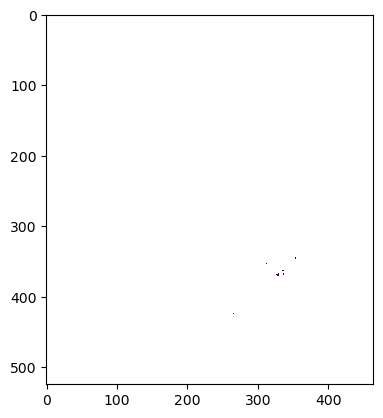

In [13]:
plt.imshow(ncompflag)